In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

from functools import partial
import ot
from easydict import EasyDict as edict

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

from iterative_sir.toy_examples_utils import prepare_25gaussian_data
from iterative_sir.toy_examples_utils.gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from iterative_sir.sampling_utils.visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_real_data, 
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           mh_sampling_normal_proposal_plot_2d,
                           sir_correlated_plot_2d,
                           sir_independent_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from iterative_sir.sampling_utils.mh_sampling import mh_sampling, mh_sampling_from_scratch
from iterative_sir.sampling_utils.ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          mh_sampling_normal_proposal,
                          #xtry_langevin_sampling,
                          gan_energy)

from iterative_sir.sampling_utils.distributions import (
                           GaussianMixture, 
                           IndependentNormal)

from iterative_sir.toy_examples_utils.params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)


from iterative_sir.sampling_utils.metrics import Evolution

In [4]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

In [5]:
from pathlib import Path
figpath = Path('../figs')

# 2D Gaussians, true distribution

In [6]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [7]:
# title = '25 Gaussians training dataset'
# path_to_save = Path(figpath, '25_gaussians_training.pdf')
# plot_real_data(X_train, title, path_to_save)

In [8]:
n_dim = 2
target_args = edict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = torch.stack([torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)], 0)
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = GaussianMixture(**target_args).log_prob


n_dim = 2
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = edict()
proposal_args.dim = n_dim
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(**proposal_args)

In [9]:
evols = dict()

In [10]:
# true_target_energy = Gaussian_mixture(target_args).energy

# x_range = 3.0
# y_range = 3.0
# title = '25 Gaussians target energy distribution'
# path_to_save = Path(figpath, '25_gaussians_energy.pdf')
# plot_potential_energy(true_target_energy,
#                       x_range,
#                       y_range,
#                       device,
#                       path_to_save = path_to_save,
#                       num_points = 100,
#                       title = title)

In [11]:
batch_size = 25 #5000
n_steps = 400
every = 50

In [17]:
# grad_step = 1e-4

# eps_scale = (grad_step * 2) ** 0.5
# n_steps = 50
# n_batches = 10
# batch_size_sample = 10000
# langevin_sampling_plot_2d(true_target,
#                           proposal,
#                           X_train,  
#                           batch_size_sample = batch_size_sample,
#                           grad_step = grad_step,
#                           eps_scale = eps_scale,
#                           n_steps = n_steps,
#                           n_batches = n_batches,
#                           path_to_save=Path(figpath, '2d_known_target_ula.pdf'))

In [12]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = langevin_sampling(true_target,
                               proposal,  
                               batch_size=batch_size,
                               n = batch_size,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)

n_chunks = len(zs[0]) // every
zs = zs[0, -n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
Xs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['ULA'] = evol

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


In [13]:
# grad_step = 1e-4
# eps_scale = (grad_step * 2) ** 0.5
# #eps_scale = 1e-2
# n_steps = 100
# n_batches = 10
# acceptance_rule = 'Hastings'
# mala_sampling_plot_2d(true_target,
#                       proposal,
#                       X_train,  
#                       batch_size_sample = batch_size_sample,
#                       grad_step = grad_step,
#                       eps_scale = eps_scale,
#                       n_steps = n_steps,
#                       n_batches = n_batches,
#                       acceptance_rule = acceptance_rule,
#                       path_to_save=Path(figpath, '2d_known_target_mala_hastings.pdf'))

In [14]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = mala_sampling(true_target,
                               proposal,  
                               batch_size=batch_size,
                               n = batch_size,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               adapt_stepsize=True,
                               acceptance_rule = 'Hastings')

zs = zs[0, -n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
Xs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['MALA'] = evol

100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


In [15]:
# plot_chain_metrics(**evols, savepath=Path(figpath, '2d_known_target_chains_metrics.pdf'))

In [16]:
# grad_step = 1e-4
# eps_scale = (grad_step * 2) ** 0.5
# n_steps = 100
# n_batches = 10
# acceptance_rule = 'Barker'
# mala_sampling_plot_2d(true_target,
#                       proposal,
#                       X_train,  
#                       batch_size_sample = batch_size_sample,
#                       grad_step = grad_step,
#                       eps_scale = eps_scale,
#                       n_steps = n_steps,
#                       n_batches = n_batches,
#                       acceptance_rule = acceptance_rule,
#                       path_to_save=Path(figpath, '2d_known_target_mala_barker.pdf'))

In [17]:
from iterative_sir.sampling_utils.sir_ais_sampling import sir_correlated_dynamics

target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

N = 5
alpha = 0.9

z_0 = proposal.sample((batch_size,))
zs = sir_correlated_dynamics(z_0,
                    true_target,
                    proposal,
                    n_steps,
                    N, 
                    alpha=alpha)

zs = torch.stack(zs, 0).detach().numpy()
zs = zs[-n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
#zs = zs[0, ::every]
Xs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['CISIR'] = evol

In [18]:
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala

target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

N = 5
corr_coef = 0.9
bernoulli_prob_corr = 0.5
mala_steps = 1

z_0 = proposal.sample((batch_size,))
zs, _, _ = ex2_mcmc_mala(z_0,
                    true_target,
                    proposal,
                    n_steps,
                    N, 
                    grad_step = grad_step,
                    noise_scale = eps_scale,
                    corr_coef=corr_coef,
                    bernoulli_prob_corr=bernoulli_prob_corr,
                    adapt_stepsize=True,
                    mala_steps = mala_steps,
                    verbose=True)

zs = torch.stack(zs, 0).detach().numpy()
zs = zs[-n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
#zs = zs[0, ::every]
Xs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['Ex$^2$MCMC-MALA'] = evol

100%|██████████| 400/400 [00:08<00:00, 47.89it/s]


In [19]:
import pickle

pickle.dump(evols, Path('../dump/gaussians_2d_metrics.pkl').open('wb')) #, evols)
evols = pickle.load(Path('../dump/gaussians_2d_metrics.pkl').open('rb'))

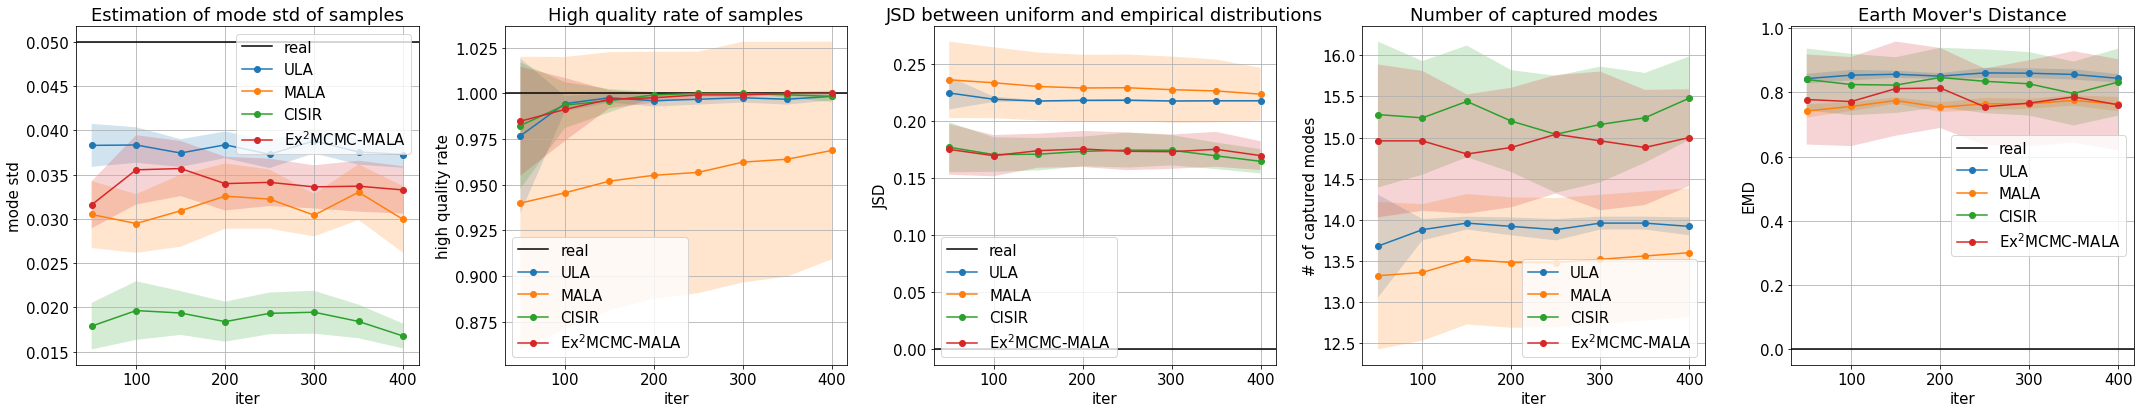

In [20]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 18 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_chain_metrics(evols, every=every, savepath=Path(figpath, 'gaussians_2d.pdf'))

# 2D Gaussians, GANs

In [12]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [13]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [14]:
models_2d_path = '../models/models_25gaussians/jensen_minimax'

In [15]:
# discriminator_regexp = Path(models_2d_path), "*_discriminator.pth")
# generator_regexp = Path(models_2d_path, "*_generator.pth")
# discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
# generator_name = [f for f in glob.glob(generator_regexp)][0]

dics_path = sorted(Path(models_2d_path).glob('*_discriminator.pth'))[0]
gen_path = sorted(Path(models_2d_path).glob('*_generator.pth'))[0]

In [16]:
G.load_state_dict(torch.load(gen_path, map_location=device))
D.load_state_dict(torch.load(dics_path, map_location=device))

<All keys matched successfully>

In [17]:
G = G.to(device)
D = D.to(device)
G.z_dim = G.n_dim

In [18]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [19]:
# batch_size_sample = 10000
# x_range = 3.0
# y_range = 3.0
# #path_to_final_save = Path(figpath, '25_gaussians_gan_samples.pdf')
# #path_to_save = figpath
# path_to_final_save = None
# path_to_save = None
# sample_fake_data(G, X_train,  
#                  x_range,
#                  y_range,
#                  scaler = scaler,
#                  path_to_save = path_to_save,
#                  path_to_final_save = path_to_final_save,
#                  batch_size_sample = batch_size_sample)

In [20]:
x_range = 3.0
y_range = 3.0
plot_discriminator_2d(D,
                      x_range,
                      y_range,
                      scaler = scaler,
                      num_points = 700,
                      path_to_save=Path(figpath, '2d_gan_discriminator.pdf'))

In [21]:
# n_calib_pts = 10000
# type_calibrator = 'isotonic'
# normalize_to_0_1 = False
# n_steps = 500
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps = n_steps,
#                     n_calib_pts = n_calib_pts,
#                     scaler = scaler, 
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator,
#                     normalize_to_0_1 = normalize_to_0_1,
#                     path_to_save=Path(figpath, '2d_gan_mhgan_isotonic.pdf'))

In [22]:
# n_calib_pts = 10000
# type_calibrator = 'linear'
# normalize_to_0_1 = False
# n_steps = 500
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps = n_steps,
#                     n_calib_pts = n_calib_pts,
#                     scaler = scaler, 
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator,
#                     normalize_to_0_1 = normalize_to_0_1,
#                     path_to_save=Path(figpath, '2d_gan_mhgan_linear.pdf'))

In [23]:
# n_calib_pts = 10000
# type_calibrator = 'isotonic'
# normalize_to_0_1 = False
# n_steps = 500
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps = n_steps,
#                     n_calib_pts = n_calib_pts,
#                     scaler = scaler, 
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator,
#                     normalize_to_0_1 = normalize_to_0_1)

In [24]:
# n_calib_pts = 10000
# type_calibrator = 'isotonic'
# normalize_to_0_1 = False
# n_steps = 500
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps = n_steps,
#                     n_calib_pts = n_calib_pts,
#                     scaler = scaler, 
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator,
#                     normalize_to_0_1 = normalize_to_0_1)

In [25]:
# n_calib_pts = 10000
# type_calibrator = 'linear'
# normalize_to_0_1 = False
# n_steps = 500
# mh_sampling_plot_2d(G, 
#                     D,
#                     X_train, 
#                     n_steps = n_steps,
#                     n_calib_pts = n_calib_pts,
#                     scaler = scaler, 
#                     batch_size_sample = batch_size_sample,
#                     type_calibrator = type_calibrator,
#                     normalize_to_0_1 = normalize_to_0_1)

In [26]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normalize_to_0_1 = True 
log_prob = True

proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(dim=n_dim, **proposal_args)

target_gan = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [27]:
evols = dict()

In [28]:
# eps_scale = 1e-3
# n_steps = 1000
# n_batches = 10
# acceptance_rule = 'Hastings'
# mh_sampling_normal_proposal_plot_2d(target_gan,
#                                     proposal,
#                                     X_train,  
#                                     path_to_save = None,
#                                     scaler = scaler, 
#                                     batch_size_sample = batch_size_sample,
#                                     eps_scale = eps_scale,
#                                     n_steps = n_steps,
#                                     acceptance_rule = acceptance_rule,
#                                     n_batches = n_batches,
#                                     latent_transform = G)

In [29]:
# N = 10
# alpha = 0.99
# n_steps = 1000
# n_batches = 10
# sir_correlated_plot_2d(target_gan,
#                        proposal,
#                        X_train,  
#                        path_to_save = None,
#                        scaler = scaler, 
#                        batch_size_sample = batch_size_sample,
#                        N = N,
#                        n_steps = n_steps,
#                        alpha = alpha,
#                        n_batches = n_batches,
#                        latent_transform = G)

In [30]:
# N = 20
# n_steps = 1000
# n_batches = 10
# sir_independent_plot_2d(target_gan,
#                         proposal,
#                         X_train,  
#                         path_to_save = None,
#                         scaler = scaler, 
#                         batch_size_sample = batch_size_sample,
#                         N = N,
#                         n_steps = n_steps,
#                         n_batches = n_batches,
#                         latent_transform = G)

In [31]:
# grad_step = 1e-3
# eps_scale = 1e-2
# n_steps = 100
# n_batches = 10
# langevin_sampling_plot_2d(target_gan,
#                           proposal,
#                           X_train,  
#                           scaler = scaler, 
#                           batch_size_sample = batch_size_sample,
#                           grad_step = grad_step,
#                           eps_scale = eps_scale,
#                           n_steps = n_steps,
#                           n_batches = n_batches,
#                           latent_transform = G,
#                           path_to_save=Path(figpath, '2d_gan_ula.pdf'))

In [32]:
# n_dim = 2
# target_args = edict()
# target_args.device = device
# target_args.num_gauss = 25
# n_col = 5
# n_row = target_args.num_gauss // n_col
# s = 1
# ###create points
# coef_gaussian = 1./target_args.num_gauss
# target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
# locs = torch.stack([torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
#         for i in range(n_col) for j in range(n_row)], 0)
# target_args.locs = locs
# target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
# target_args.dim = n_dim
# true_target = GaussianMixture(**target_args).log_prob


# n_dim = 2
# loc_proposal = torch.zeros(n_dim).to(device)
# scale_proposal = torch.ones(n_dim).to(device)
# proposal_args = edict()
# proposal_args.device = device
# proposal_args.loc = loc_proposal
# proposal_args.scale = scale_proposal
# proposal = IndependentNormal(dim=n_dim, **proposal_args)

In [33]:
evols = dict()

In [66]:
batch_size = 50 #5000
n_steps = 1000
every = 100

In [72]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 3e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = langevin_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size,
                               n = batch_size,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)

n_chunks = len(zs[0]) // every
zs = zs[0, -n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
zs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=locs, 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['ULA'] = evol

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [68]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = mala_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size,
                               n = batch_size,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               adapt_stepsize=True,
                               acceptance_rule = 'Hastings')

n_chunks = len(zs[0]) // every
zs = zs[0, -n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
zs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=locs, 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['MALA'] = evol

100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


In [69]:
from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala

target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-2
eps_scale = (grad_step * 2) ** 0.5

N = 10
corr_coef = 0.9
bernoulli_prob_corr = 0.5
mala_steps = 1

z_0 = proposal.sample((batch_size,))
zs = ex2_mcmc_mala(z_0,
                    target_gan,
                    proposal,
                    n_steps,
                    N, 
                    grad_step = grad_step,
                    noise_scale = eps_scale,
                    corr_coef=corr_coef,
                    bernoulli_prob_corr=bernoulli_prob_corr,
                    adapt_stepsize=True,
                    mala_steps = mala_steps,
                    verbose=True)
zs = zs[0]
n_chunks = len(zs) // every
zs = torch.stack(zs, 0).detach().numpy()
zs = zs[-n_chunks * every:].reshape((n_chunks, batch_size, -1, zs.shape[-1]))
#zs = zs[0, ::every]
zs_gen = zs.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

evol = defaultdict(list)
for X_gen in Xs_gen:
    evolution = Evolution(target_sample, locs=locs, 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)
    for chunk in X_gen:
        evolution.invoke(torch.FloatTensor(chunk))
    evol_ = evolution.as_dict()
    for k, v in evol_.items():
        evol[k].append(v)

for k, v in evol.items():
    evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
evols['Ex$^2$MCMC-MALA'] = evol

100%|██████████| 1000/1000 [00:06<00:00, 156.82it/s]


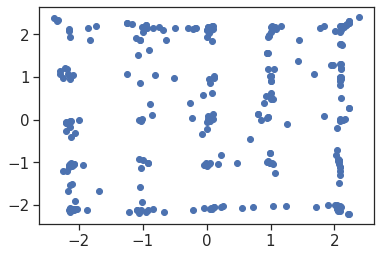

In [70]:
chain_id = 10

plt.scatter(Xs_gen[chain_id, -3:, :, 0].reshape(-1), Xs_gen[chain_id, -3:, :, 1].reshape(-1))

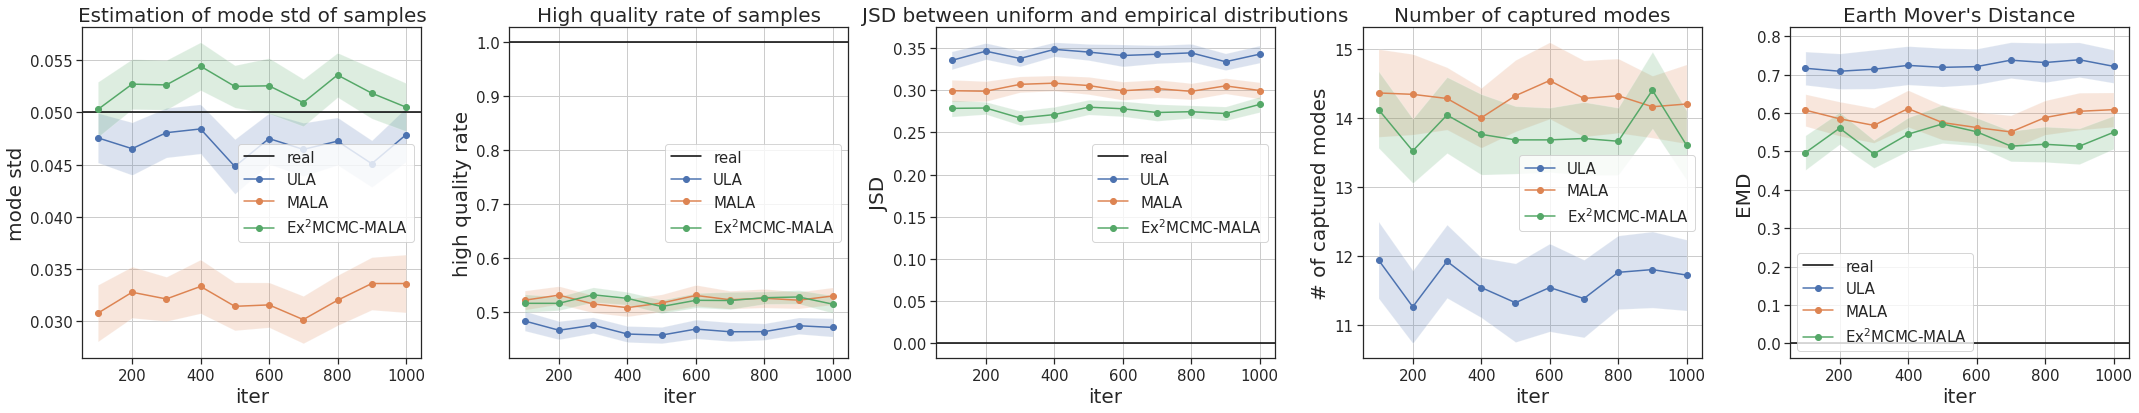

In [73]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15  # 8
MEDIUM_SIZE = 20  # 10
BIGGER_SIZE = 20  # 12

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_chain_metrics(evols, every=every, savepath=Path(figpath, 'gan_gaussians_2d.pdf'))

In [72]:
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

# q = 0.999
# evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
#                       target_log_prob=true_target, sigma=sigma, scaler=scaler,
#                       q=q)

# n_steps = 1000
# every = 50
# grad_step = 1e-3
# eps_scale = 1e-2 #(grad_step * 2) ** 0.5 #1e-1
# z_last_np, zs = langevin_sampling(target_gan,
#                                proposal,  
#                                batch_size=batch_size_sample,
#                                n = batch_size_sample,
#                                grad_step = grad_step,
#                                eps_scale = eps_scale,
#                                n_steps = n_steps)#,
#                                #n_batches = n_batches)

# zs = zs[0, ::every]

# Xs_gen = G(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
# Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen).to(device))
# evol = evolution.as_dict()
# evols['ULA'] = evol

In [73]:
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

# q = 0.999
# evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
#                       target_log_prob=true_target, sigma=sigma, scaler=scaler,
#                       q=q)

# n_steps = 1000
# every = 50

# grad_step = 1e-3
# eps_scale = 1e-2

# z_last_np, zs = mala_sampling(target_gan,
#                                proposal,  
#                                batch_size=batch_size_sample,
#                                n = batch_size_sample,
#                                grad_step = grad_step,
#                                eps_scale = eps_scale,
#                                n_steps = n_steps,
#                                acceptance_rule = 'Hastings')#,
#                                #n_batches = n_batches)

# zs = zs[0, ::every]
# Xs_gen = zs

# Xs_gen = G(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
# Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen).to(device))
# evol = evolution.as_dict()
# evols[f'MALA, MH'] = evol

In [74]:
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]
# q = 0.999
# evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
#                       target_log_prob=true_target, sigma=sigma, scaler=scaler,
#                       q = q)

# n_steps = 1000
# every = 50

# grad_step = 1e-3
# eps_scale = 1e-2

# z_last_np, zs = mala_sampling(target_gan,
#                                proposal,  
#                                batch_size=batch_size_sample,
#                                n = batch_size_sample,
#                                grad_step = grad_step,
#                                eps_scale = eps_scale,
#                                n_steps = n_steps,
#                                acceptance_rule = 'Barker')#,
#                                #n_batches = n_batches)

# zs = zs[0, ::every]
# Xs_gen = zs

# Xs_gen = G(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
# Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen).to(device))
# evol = evolution.as_dict()
# evols[f'MALA, Barker'] = evol

In [75]:
# n_calib_pts = 10000
# type_calibrator = 'isotonic'
# normalize_to_0_1 = False
# n_steps = 500
# every = 50

# if scaler is not None:
#     X_train_scale = scaler.transform(X_train)
# else:
#     X_train_scale = X_train

# zs = []
# num_steps = [1] + [(i + 1)*every for i in range(20)]
# for num_step in num_steps:
#     print(f"num step = {num_step}")
#     X_mh = mh_sampling_from_scratch(X_train_scale,
#                                     G,
#                                     D,
#                                     G.device,
#                                     n_calib_pts,
#                                     batch_size_sample=batch_size_sample,
#                                     n_steps=num_step,
#                                     type_calibrator=type_calibrator,
#                                     normalize_to_0_1=normalize_to_0_1)
#     zs.append(X_mh)

In [76]:
# zs[0].shape

In [77]:
# zs_concat = np.array(zs)
# print(zs_concat.shape)

In [14]:
# evols = dict()


In [121]:
# path_to_save_mhgan_res = '/home/daniil/gans-mcmc/saved_numpy_arrays/mhgan_isotonic.np'
# np.save(path_to_save_mhgan_res, zs_concat)

In [26]:
# path_to_save_mhgan_res = '/home/daniil/gans-mcmc/saved_numpy_arrays/mhgan_isotonic.np.npy'
# zs_concat = np.load(path_to_save_mhgan_res)

In [78]:
# Xs_gen = zs_concat
# type_calibrator = 'isotonic'
# q = 0.999
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

# evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
#                       target_log_prob=true_target, sigma=sigma, scaler=scaler)

# #Xs_gen = G(torch.FloatTensor(zs_concat).to(device)).detach().cpu().numpy()
# Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen).to(device))
# evol = evolution.as_dict()
# evols[f'MHGAN, calibrator = {type_calibrator}'] = evol

In [79]:
# plot_chain_metrics(**evols, savepath=Path(figpath, '2d_gan_chain_metrics.pdf'))




In [80]:
# evols["MHGAN, calibrator = isotonic"]

In [81]:
# grad_step = 1e-3
# eps_scale = 1e-2
# n_steps = 500
# n_batches = 10
# acceptance_rule = 'Barker'
# mala_sampling_plot_2d(target_gan,
#                       proposal,
#                       X_train,  
#                       scaler = scaler, 
#                       batch_size_sample = batch_size_sample,
#                       grad_step = grad_step,
#                       eps_scale = eps_scale,
#                       n_steps = n_steps,
#                       n_batches = n_batches,
#                       acceptance_rule = acceptance_rule,
#                       latent_transform = G,
#                       path_to_save=Path(figpath, '2d_gan_mala_barker.pdf'))

In [82]:
# plot_chain_metrics(**evols, savepath=Path(figpath, '2d_gan_chain_metrics.pdf'))

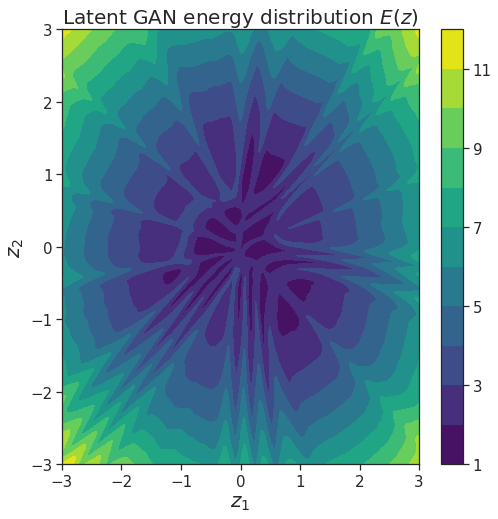

In [59]:
log_prob = False
target_gan_energy = partial(gan_energy, 
                            generator = G, 
                            discriminator = D, 
                            proposal = proposal,
                            normalize_to_0_1 = normalize_to_0_1,
                            log_prob = log_prob)
x_range = 3.0
y_range = 3.0
norm_grads = False
title = r'Latent GAN energy distribution $E(z)$'
path_to_save = Path(figpath, 'latent_gan_energy.pdf')
mode_visual = 'latent'
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      path_to_save = path_to_save,
                      norm_grads = norm_grads,
                      num_points = 700,
                      title = title,
                      mode_visual = mode_visual)

In [83]:
# grad_step = 1e-3
# eps_scale = 1e-2
# n_steps = 100
# n_batches = 10
# batchsize = batch_size_sample // n_batches
# X_langevin, zs = langevin_sampling(target_gan, proposal, batchsize, batch_size_sample, 
#                                        None, None, None, None, 
#                                        n_steps, grad_step, eps_scale)

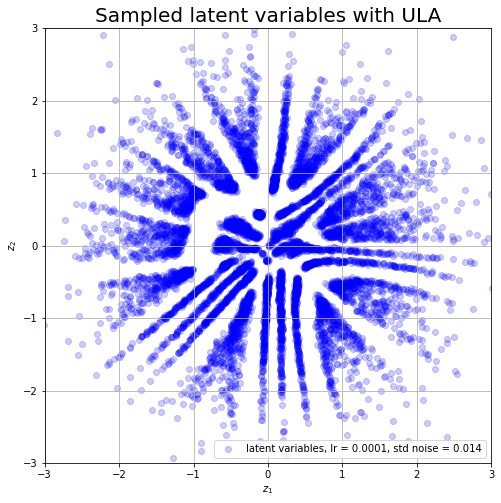

In [78]:
path_to_save = Path(figpath, 'latent_variables_ula.pdf')
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Sampled latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(X_langevin[:,:1], X_langevin[:,1:], alpha=0.2, color='blue', 
            marker='o', label = f'latent variables, lr = {grad_step}, std noise = {round(eps_scale, 3)}')
plt.grid(True)
plt.xlabel(r"$z_{1}$")
plt.ylabel(r"$z_{2}$")
plt.legend()
plt.savefig(path_to_save)
plt.show()

In [96]:
z_ex2 = zs[5:].reshape(zs.shape[1], -1, 2)
chain_id = 11
z_ex2_single = z_ex2.reshape(-1, 2) #[chain_id]

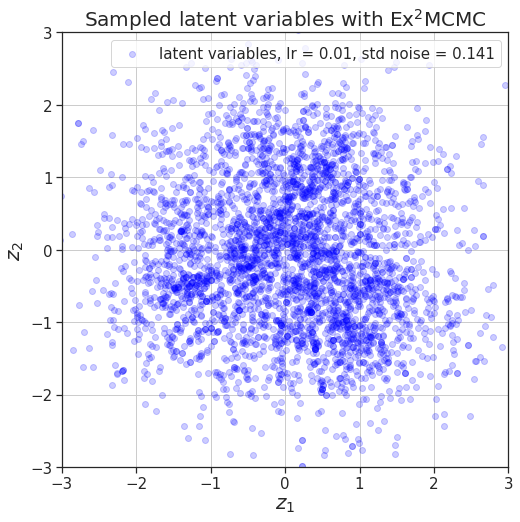

In [97]:
path_to_save = Path(figpath, 'latent_variables_ex2mcmc.pdf')
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = fr"Sampled latent variables with Ex$^2$MCMC"
plt.title(title, fontsize=20)
plt.scatter(z_ex2_single[:,:1], z_ex2_single[:,1:], alpha=0.2, color='blue', 
            marker='o', label = f'latent variables, lr = {grad_step}, std noise = {round(eps_scale, 3)}')
plt.grid(True)
plt.xlabel(r"$z_{1}$")
plt.ylabel(r"$z_{2}$")
plt.legend()
plt.savefig(path_to_save)
plt.show()